In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_datareader import data as wb
import seaborn as sns
import yfinance
import scipy.stats
import pylab
import ccxt
import calendar
from datetime import datetime, date, timedelta
from statsmodels.tsa.arima_model import ARMA, ARIMA

#import statsmodels.graphics.tsaplots as sgt
#from statsmodels.tsa.arima_model import ARMA
#from scipy.stats.distributions import chi2
#import statsmodels.tsa.stattools as sts 
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [69]:


binance = ccxt.binance()

def min_ohlcv(dt, pair, limit):
    # UTC native object
    since = calendar.timegm(dt.utctimetuple())*1000
    ohlcv1 = binance.fetch_ohlcv(symbol=pair, timeframe='1m', since=since, limit=limit)
    ohlcv2 = binance.fetch_ohlcv(symbol=pair, timeframe='1m', since=since, limit=limit)
    ohlcv = ohlcv1 + ohlcv2
    return ohlcv



In [70]:
def ohlcv(dt, pair, period='1d'):
    ohlcv = []
    limit = 1000
    if period == '1m':
        limit = 720
    elif period == '1d':
        limit = 365
    elif period == '1h':
        limit = 24
    elif period == '5m':
        limit = 288
    for i in dt:
        start_dt = datetime.strptime(i, "%Y%m%d")
        since = calendar.timegm(start_dt.utctimetuple())*1000
        if period == '1m':
            ohlcv.extend(min_ohlcv(start_dt, pair, limit))
        else:
            ohlcv.extend(binance.fetch_ohlcv(symbol=pair, timeframe=period, since=since, limit=limit))
    df = pd.DataFrame(ohlcv, columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Time'] = [datetime.fromtimestamp(float(time)/1000) for time in df['Time']]
    df['Open'] = df['Open'].astype(np.float64)
    df['High'] = df['High'].astype(np.float64)
    df['Low'] = df['Low'].astype(np.float64)
    df['Close'] = df['Close'].astype(np.float64)
    df['Volume'] = df['Volume'].astype(np.float64)
    df.set_index('Time', inplace=True)
    return df


In [71]:
dt = ['20201001', '20211001']
df = ohlcv(dt, 'BTC/USDT', '1d')

In [72]:
BTC=df.iloc[:,3]

In [73]:
BTC

Time
2020-09-30 19:00:00    10619.13
2020-10-01 19:00:00    10570.40
2020-10-02 19:00:00    10542.06
2020-10-03 19:00:00    10666.63
2020-10-04 19:00:00    10792.21
                         ...   
2021-10-07 19:00:00    53951.43
2021-10-08 19:00:00    54949.72
2021-10-09 19:00:00    54659.00
2021-10-10 19:00:00    57471.35
2021-10-11 19:00:00    57093.55
Name: Close, Length: 377, dtype: float64

In [74]:
def get_tickets_close(tickets):
    info = yfinance.download(tickers = tickets, interval ='1d',start='2016-01-01', end ='2021-09-09', groub_by = 'ticker',auto_adjust = True, treads = True)['Close']
    return info

In [75]:
BTC = ["BTC-USD"]
BTC = get_tickets_close(BTC)
BTC.tail()

[*********************100%***********************]  1 of 1 completed


Date
2021-09-05    51753.410156
2021-09-06    52633.535156
2021-09-07    46811.128906
2021-09-08    46091.390625
2021-09-09    46391.421875
Name: Close, dtype: float64

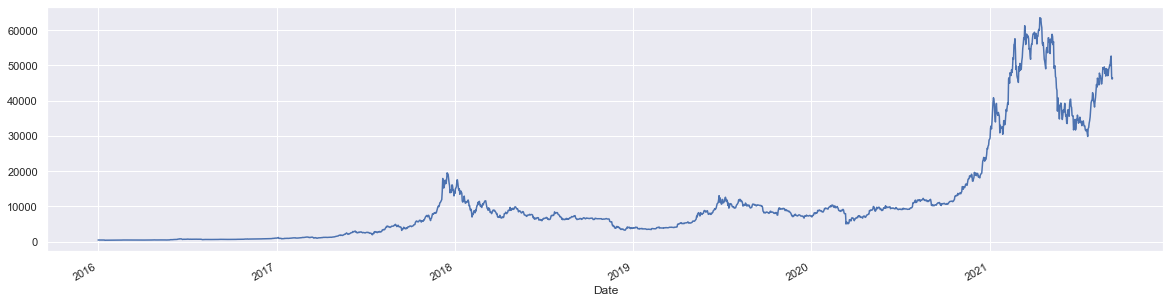

In [76]:
BTC.plot(figsize=(20,5))
plt.show()

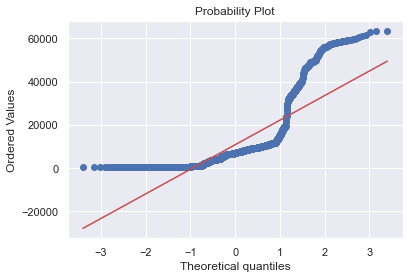

In [77]:
scipy.stats.probplot(BTC, plot = pylab)
pylab.show()

# AR analisis

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

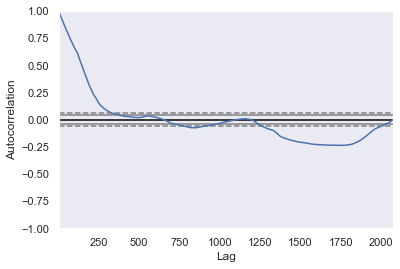

In [78]:
pd.plotting.autocorrelation_plot(BTC, ax = None)

## The ACF

In [79]:
from matplotlib import pyplot

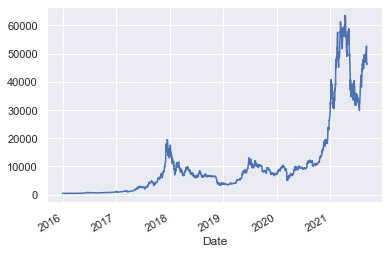

In [80]:
BTC.plot()
pyplot.show()

In [81]:
from binance.client import Client

import matplotlib.animation as animation
import mplfinance as mpf
import pandas as pd
import numpy as np

api_key    = 'xxxxxxxxxxxxxxxxxxxxxxxxx'
api_secret = 'xxxxxxxxxxxxxxxxxxxxxxxxx'

crypto = 'BTCUSDT'
kline_interval = Client.KLINE_INTERVAL_1MINUTE

client = Client(api_key, api_secret)
klines = client.get_historical_klines(crypto, kline_interval, "1 hour ago UTC")

df = pd.DataFrame(klines,  columns=['Date',
                                    'Open',
                                    'High',
                                    'Low',
                                    'Close',
                                    'Volume',
                                    'Close time',
                                    'Quote asset volume',
                                    'Number of trades',
                                    'Taker buy base asset volume',
                                    'Taker buy quote asset volume',
                                    'Ignore'])

df = df.drop(df.columns[[6, 7, 8, 9, 10, 11]], axis=1)
df['Date'] = pd.to_datetime(df['Date'], unit='ms')
df.set_index('Date', inplace=True, drop=True)

df['Open']   = df['Open'].astype(float)
df['High']   = df['High'].astype(float)
df['Low']    = df['Low'].astype(float)
df['Close']  = df['Close'].astype(float)
df['Volume'] = df['Volume'].astype(float)

pkwargs=dict(type='candle', style='binance')
fig, axes = mpf.plot(df, title='Bitcoin Price in Binance', volume=True, returnfig=True, **pkwargs)

ax1 = axes[0]
ax2 = axes[2]

def animate(ival):

    candle = client.get_klines(symbol=crypto, interval=kline_interval, limit=1)

    c_open  = float(candle[0][1])
    c_high  = float(candle[0][2])
    c_low   = float(candle[0][3])
    c_close = float(candle[0][4])
    c_vol   = float(candle[0][5])
    
    df2 = pd.DataFrame({'Date':[candle[0][0]], 'Open':[c_open],'High':[c_high],'Low':[c_low],'Close':[c_close],'Volume':[c_vol]})
    df2['Date'] = pd.to_datetime(df2['Date'], unit='ms')
    df2.set_index('Date', inplace=True, drop=True)

    global df

    if df.last_valid_index() != df2.last_valid_index():
        data = pd.concat([df.iloc[1:], df2], ignore_index = False) 
        df = data
    else:
        data = df    
        data.iloc[-1, data.columns.get_loc('Open')]   = c_open
        data.iloc[-1, data.columns.get_loc('High')]   = c_high
        data.iloc[-1, data.columns.get_loc('Low')]    = c_low
        data.iloc[-1, data.columns.get_loc('Close')]  = c_close
        data.iloc[-1, data.columns.get_loc('Volume')] = c_vol
    
    ax1.clear()
    ax2.clear()

    mpf.plot(data, ax=ax1,volume=ax2,**pkwargs)

ani = animation.FuncAnimation(fig, animate, interval=250)

mpf.show()

ModuleNotFoundError: No module named 'binance'

In [82]:
df.head()

,Open,High,Low,Close,Volume
Time,,,,,
2020-09-30 19:00:00,10776.59,10920.00,10437.00,10619.13,60866.332893
2020-10-01 19:00:00,10619.13,10664.64,10374.00,10570.40,50130.393705
2020-10-02 19:00:00,10570.40,10603.56,10496.46,10542.06,22298.221341
2020-10-03 19:00:00,10542.07,10696.87,10517.87,10666.63,23212.001595
2020-10-04 19:00:00,10666.62,10798.00,10615.64,10792.21,34025.761653


Codigo obtenido de : http://acodigo.blogspot.com/2021/01/python-binance-api.html

## The Lag Plot

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='y(t)', ylabel='y(t + 2)'>

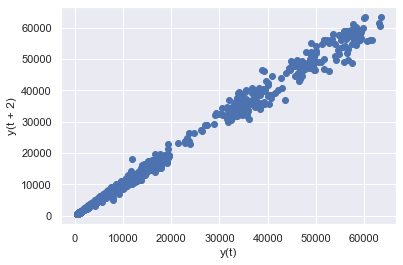

In [83]:
pd.plotting.lag_plot(BTC, lag=2)

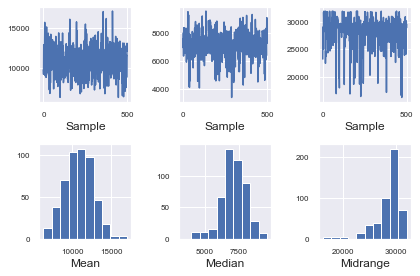

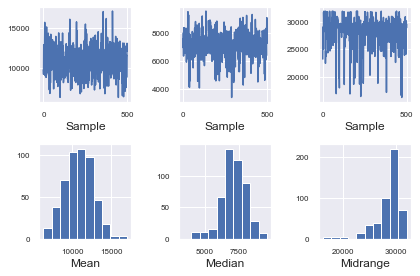

In [84]:
pd.plotting.bootstrap_plot(BTC)

## THE PACF

In [85]:
pd.plot_pacf(BTC, lags = 50, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF for BTC prices", size = 20)
plt.show()

AttributeError: module 'pandas' has no attribute 'plot_pacf'

# The AR(1) model

In [86]:
model_ar = ARMA(BTC, order=(1,0))

In [87]:
results_ar = model_ar.fit()

In [88]:
results_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2075
Model:                     ARMA(1, 0)   Log Likelihood              -16687.888
Method:                       css-mle   S.D. of innovations            751.329
Date:                Mon, 11 Oct 2021   AIC                          33381.775
Time:                        20:51:18   BIC                          33398.688
Sample:                             0   HQIC                         33387.974
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.079e+04   1.73e+04      0.622      0.534   -2.32e+04    4.48e+04
ar.L1.Close     0.9993      0.001   1089.165      0.000       0.997       1.001
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0007           +0.0000j            1.0007            0.0000
-----------------------------------------------------------------------------
"""

In [89]:
def LLR_test(mod_1, mod_2, DF=1):
    "mod_1 = place the first model, mod_2= place your second model, DF = degrees of freedom, 1 degree of freedom by default"
    L1 = mod_1.fit().llf
    L2 = mod_2.fit().llf
    LR = (2*(L2-L1))
    p = chi2.sf(LR, DF).round(3)
    return p

In [90]:
model_ar2 = ARMA(BTC, order=(2,0))
results_ar2 = model_ar2.fit()
results_ar2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2075
Model:                     ARMA(2, 0)   Log Likelihood              -16684.344
Method:                       css-mle   S.D. of innovations            750.037
Date:                Mon, 11 Oct 2021   AIC                          33376.688
Time:                        20:51:19   BIC                          33399.239
Sample:                             0   HQIC                         33384.953
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.079e+04   1.88e+04      0.574      0.566   -2.61e+04    4.76e+04
ar.L1.Close     0.9409      0.021     44.712      0.000       0.900       0.982
ar.L2.Close     0.0584      0.021      2.774      0.006       0.017       0.100
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0006           +0.0000j            1.0006            0.0000
AR.2          -17.1066           +0.0000j           17.1066            0.5000
-----------------------------------------------------------------------------
"""

In [91]:
model_ar_2 = ARMA(BTC, order = (2,0))
results_model_ar_2 = model_ar_2.fit()
print(results_model_ar_2 .summary())
print ("LLR test: " + str(LLR_test(model_ar, model_ar_2)))

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2075
Model:                     ARMA(2, 0)   Log Likelihood              -16684.344
Method:                       css-mle   S.D. of innovations            750.037
Date:                Mon, 11 Oct 2021   AIC                          33376.688
Time:                        20:51:20   BIC                          33399.239
Sample:                             0   HQIC                         33384.953
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.079e+04   1.88e+04      0.574      0.566   -2.61e+04    4.76e+04
ar.L1.Close     0.9409      0.021     44.712      0.000       0.900       0.982
ar.L2.Close     0.0584      0.021      2.774    

NameError: name 'chi2' is not defined

**Tomando un 5% de nivel de significancia, el modelo 2 es mejor que el 1**

In [92]:
model_ar_3 = ARMA(BTC, order = (3,0))
results_model_ar_3 = model_ar_3.fit()
print(results_model_ar_3 .summary())
print ("LLR test: " + str(LLR_test(model_ar2, model_ar_3)))

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2075
Model:                     ARMA(3, 0)   Log Likelihood              -16680.525
Method:                       css-mle   S.D. of innovations            748.665
Date:                Mon, 11 Oct 2021   AIC                          33371.050
Time:                        20:51:21   BIC                          33399.239
Sample:                             0   HQIC                         33381.381
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.079e+04   1.73e+04      0.626      0.532    -2.3e+04    4.46e+04
ar.L1.Close     0.9445      0.021     44.250      0.000       0.903       0.986
ar.L2.Close     0.1154      0.030      3.887    

NameError: name 'chi2' is not defined

**Tomando un 5% de nivel de significancia, el modelo 3 es mejor que el 2**

In [ ]:
model_ar_4 = ARMA(BTC, order = (4,0))
results_model_ar_4 = model_ar_4.fit()
print(results_model_ar_4 .summary())
print ("LLR test: " + str(LLR_test(model_ar_3, model_ar_4)))

**Tomando un nivel de significancia de 5% el modelo 4 NO es mejor que el modelo 3**

In [ ]:
model_ar_5 = ARMA(BTC, order = (5,0))
results_model_ar_5 = model_ar_5.fit()
print(results_model_ar_5 .summary())
print ("LLR test: " + str(LLR_test(model_ar_4, model_ar_5)))

**Tomando un nivel de significancia de 5% el modelo 4 NO es mejor que el modelo 3**

In [93]:
sts.adfuller(BTC)

NameError: name 'sts' is not defined

El p value de la prueba de dickey fuller es de: .929, por lo que podemos deducir que nuestra información no viene de un proceso estacionario, a un nivel de significancia del 5%, esto viene de un proceso no estacionario.

## Usando retornos en vez de precios

In [94]:
BTC_returns = pd.DataFrame(BTC.pct_change(1).mul(100))
BTC_returns = BTC_returns[1:]
BTC_returns

,Close
Date,
2016-01-02,-0.206299
2016-01-03,-0.790656
2016-01-04,0.716265
2016-01-05,-0.261149
2016-01-06,-0.660936
...,...
2021-09-05,3.621581
2021-09-06,1.700613
2021-09-07,-11.062161


In [95]:
sts.adfuller(BTC_returns)

NameError: name 'sts' is not defined

El p value de la prueba de dickey fuller es de: 0.0, por lo que podemos deducir que nuestra información viene de un proceso estacionario, a un nivel de significancia del 5%.

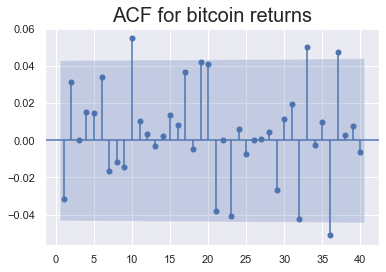

In [20]:
sgt.plot_acf(BTC_returns, zero=False, lags=40)
plt.title("ACF for bitcoin returns", size= 20)
plt.show()

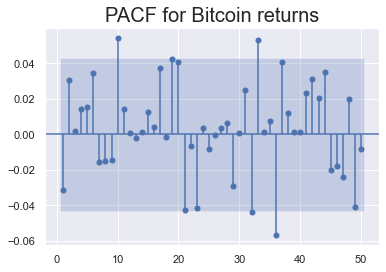

In [21]:
sgt.plot_pacf(BTC_returns, lags = 50, alpha = 0.05, zero = False, method = ('ols'))
plt.title("PACF for Bitcoin returns", size = 20)
plt.show()

# Ar for models

In [22]:
model_ret_ar = ARMA(BTC_returns, order=(1,0))
results_ret_ar = model_ret_ar.fit()
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2074
Model:                     ARMA(1, 0)   Log Likelihood               -5814.408
Method:                       css-mle   S.D. of innovations              3.993
Date:                Sat, 02 Oct 2021   AIC                          11634.815
Time:                        18:43:56   BIC                          11651.727
Sample:                             0   HQIC                         11641.013
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3060      0.085      3.599      0.000       0.139       0.473
ar.L1.Close    -0.0314      0.022     -1.433      0.152      -0.074       0.012
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -31.8074           +0.0000j           31.8074            0.5000
-----------------------------------------------------------------------------
"""

In [23]:
model_ret_ar2 = ARMA(BTC_returns, order = (2,0))
results_model_ret_ar2 = model_ret_ar2.fit()
print(results_model_ret_ar2 .summary())
print ("LLR test: " + str(LLR_test(model_ret_ar, model_ret_ar2)))

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2074
Model:                     ARMA(2, 0)   Log Likelihood               -5813.438
Method:                       css-mle   S.D. of innovations              3.991
Date:                Sat, 02 Oct 2021   AIC                          11634.877
Time:                        18:43:56   BIC                          11657.426
Sample:                             0   HQIC                         11643.141
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3059      0.088      3.491      0.000       0.134       0.478
ar.L1.Close    -0.0305      0.022     -1.389      0.165      -0.073       0.013
ar.L2.Close     0.0306      0.022      1.393    

In [24]:
model_ret_ar3 = ARMA(BTC_returns, order = (3,0))
results_model_ret_ar3 = model_ret_ar3.fit()
print(results_model_ret_ar3 .summary())
print ("LLR test: " + str(LLR_test(model_ret_ar2, model_ret_ar3)))

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2074
Model:                     ARMA(3, 0)   Log Likelihood               -5813.434
Method:                       css-mle   S.D. of innovations              3.991
Date:                Sat, 02 Oct 2021   AIC                          11636.869
Time:                        18:43:57   BIC                          11665.055
Sample:                             0   HQIC                         11647.199
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3059      0.088      3.484      0.000       0.134       0.478
ar.L1.Close    -0.0305      0.022     -1.391      0.164      -0.074       0.012
ar.L2.Close     0.0306      0.022      1.395    

In [25]:
model_ret_ar4 = ARMA(BTC_returns, order = (4,0))
results_model_ret_ar4 = model_ret_ar4.fit()
print(results_model_ret_ar4 .summary())
print ("LLR test: " + str(LLR_test(model_ret_ar3, model_ret_ar4)))

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2074
Model:                     ARMA(4, 0)   Log Likelihood               -5813.228
Method:                       css-mle   S.D. of innovations              3.991
Date:                Sat, 02 Oct 2021   AIC                          11638.457
Time:                        18:43:57   BIC                          11672.280
Sample:                             0   HQIC                         11650.853
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3058      0.089      3.434      0.001       0.131       0.480
ar.L1.Close    -0.0306      0.022     -1.392      0.164      -0.074       0.012
ar.L2.Close     0.0302      0.022      1.374    

In [26]:
model_ret_ar9 = ARMA(BTC_returns, order = (9,0))
results_model_ret_ar9 = model_ret_ar9.fit()
print(results_model_ret_ar9 .summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2074
Model:                     ARMA(9, 0)   Log Likelihood               -5811.060
Method:                       css-mle   S.D. of innovations              3.987
Date:                Sat, 02 Oct 2021   AIC                          11644.121
Time:                        18:43:59   BIC                          11706.130
Sample:                             0   HQIC                         11666.848
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3058      0.089      3.417      0.001       0.130       0.481
ar.L1.Close    -0.0312      0.022     -1.423      0.155      -0.074       0.012
ar.L2.Close     0.0302      0.022      1.374    

In [27]:
model_ret_ar10 = ARMA(BTC_returns, order = (10,0))
results_model_ret_ar10 = model_ret_ar10.fit()
print(results_model_ret_ar10.summary())

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2074
Model:                    ARMA(10, 0)   Log Likelihood               -5808.021
Method:                       css-mle   S.D. of innovations              3.981
Date:                Sat, 02 Oct 2021   AIC                          11640.041
Time:                        18:44:02   BIC                          11707.688
Sample:                             0   HQIC                         11664.834
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3057      0.094      3.237      0.001       0.121       0.491
ar.L1.Close     -0.0304      0.022     -1.389      0.165      -0.073       0.013
ar.L2.Close      0.0310      0.022      1.41

In [28]:
model_ret_ar10 = ARMA(BTC_returns, order = (10,0))
results_model_ret_ar10 = model_ret_ar10.fit()
print(results_model_ret_ar10 .summary())
print ("LLR test: " + str(LLR_test(model_ret_ar, model_ret_ar10)))

                              ARMA Model Results                              
Dep. Variable:                  Close   No. Observations:                 2074
Model:                    ARMA(10, 0)   Log Likelihood               -5808.021
Method:                       css-mle   S.D. of innovations              3.981
Date:                Sat, 02 Oct 2021   AIC                          11640.041
Time:                        18:44:07   BIC                          11707.688
Sample:                             0   HQIC                         11664.834
                                                                              
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.3057      0.094      3.237      0.001       0.121       0.491
ar.L1.Close     -0.0304      0.022     -1.389      0.165      -0.073       0.013
ar.L2.Close      0.0310      0.022      1.41

In [29]:
sts.adfuller(BTC_returns)

(-31.68205835408799,
 0.0,
 1,
 2072,
 {'1%': -3.4335099516667325,
  '5%': -2.8629359231480236,
  '10%': -2.5675131253354153},
 11474.059472809327)

# Analyzing residuals

In [30]:
BTC['res_price']= results_model_ar_4.resid
BTC

Date
2016-01-01 00:00:00                                              434.334
2016-01-02 00:00:00                                              433.438
2016-01-03 00:00:00                                              430.011
2016-01-04 00:00:00                                              433.091
2016-01-05 00:00:00                                               431.96
                                             ...                        
2021-09-06 00:00:00                                              52633.5
2021-09-07 00:00:00                                              46811.1
2021-09-08 00:00:00                                              46091.4
2021-09-09 00:00:00                                              46391.4
res_price              Date
2016-01-01   -10359.007856
2016-01-02    ...
Name: Close, Length: 2076, dtype: object

In [31]:
BTC.res_price.mean()

16.286138213637347

In [32]:
BTC.res_price.var()

611747.9931066977

In [33]:
sts.adfuller(BTC.res_price)

(-7.8900913318727905,
 4.460452487944143e-12,
 26,
 2048,
 {'1%': -3.433547028919612,
  '5%': -2.8629522934224085,
  '10%': -2.5675218415927885},
 32881.27126473035)

# ARMA (1,1)

In [34]:
model_ret_ar1_ma1 = ARMA(BTC_returns[1:], order=(1,1))
results_ret_ar1_ma1 = model_ret_ar1_ma1.fit()
results_ret_ar1_ma1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2073
Model:                     ARMA(1, 1)   Log Likelihood               -5811.009
Method:                       css-mle   S.D. of innovations              3.992
Date:                Sat, 02 Oct 2021   AIC                          11630.017
Time:                        18:44:13   BIC                          11652.564
Sample:                             0   HQIC                         11638.281
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3063      0.086      3.541      0.000       0.137       0.476
ar.L1.Close    -0.8377      0.175     -4.794      0.000      -1.180      -0.495
ma.L1.Close     0.8131      0.186      4.362      0.000       0.448       1.178
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.1937           +0.0000j            1.1937            0.5000
MA.1           -1.2299           +0.0000j            1.2299            0.5000
-----------------------------------------------------------------------------
"""

In [35]:
model_ret_ar1 = ARMA(BTC_returns[1:], order=(1,0))
model_ret_ma1 = ARMA(BTC_returns[1:], order=(0,1))

In [36]:
model_ret_ar = ARMA(BTC_returns[1:], order=(1,0))
results_ret_ar = model_ret_ar.fit()
results_ret_ar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2073
Model:                     ARMA(1, 0)   Log Likelihood               -5812.095
Method:                       css-mle   S.D. of innovations              3.994
Date:                Sat, 02 Oct 2021   AIC                          11630.189
Time:                        18:44:14   BIC                          11647.100
Sample:                             0   HQIC                         11636.387
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3062      0.085      3.601      0.000       0.140       0.473
ar.L1.Close    -0.0315      0.022     -1.433      0.152      -0.074       0.012
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -31.7891           +0.0000j           31.7891            0.5000
-----------------------------------------------------------------------------
"""

In [37]:
model_ret_ma = ARMA(BTC_returns[1:], order=(0,1))
results_ret_ma = model_ret_ma.fit()
results_ret_ma.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Close   No. Observations:                 2073
Model:                     ARMA(0, 1)   Log Likelihood               -5812.155
Method:                       css-mle   S.D. of innovations              3.994
Date:                Sat, 02 Oct 2021   AIC                          11630.310
Time:                        18:44:14   BIC                          11647.220
Sample:                             0   HQIC                         11636.507
                                                                              
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.3062      0.085      3.597      0.000       0.139       0.473
ma.L1.Close    -0.0296      0.021     -1.391      0.164      -0.071       0.012
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           33.7660           +0.0000j           33.7660            0.0000
-----------------------------------------------------------------------------
"""

In [38]:
LLR_test(model_ret_ar1_ma1,model_ret_ar)

1.0

In [39]:
LLR_test(model_ret_ar1_ma1,model_ret_ma)

1.0

In [40]:
LLR_test(model_ret_ma,model_ret_ar)

0.729